![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Introduction to Machine Learning </center>
## <center> Lecture 22 - RNN</center>
### <center> Music Generation with RNN</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/IntroductionToMachineLearning/22_RNN/MainMusicGeneration1.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy            as np
import torch.nn         as nn
import torch.utils.data as data
import torch

from matplotlib import pyplot as plt

For Colab users:

In [39]:
#-- Colab users shouls install these two modules:
# !pip install pretty_midi
# !pip install pygame

In [3]:
!wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/IntroductionToMachineLearning/22_RNN/MusicGenerationAux.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
#-- Record figures during training:
from MusicGenerationAux import Plot, Recorder, TrainLoop, ValidationLoop, TrainModel, LearningRateSweep, OneCycleScheduler, ReadMidi, PlayMidi

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


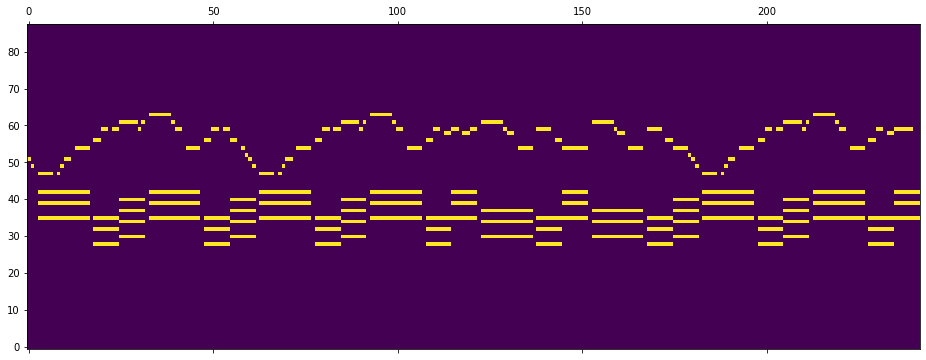

(88, 484)

In [14]:
mX = ReadMidi('../../data/Nottingham/train/waltzes_simple_chords_12.mid')
_, ax = plt.subplots(figsize=(16, 10))
ax.matshow(mX[:,:1000:2], origin='lower')
plt.show()
mX.shape

In [16]:
PlayMidi(mX, Fs=20)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Or\OneDrive\FixelAlgorithms\FixelCourses\IntroductionToMachineLearning\22_RNN\MusicGenerationAux.py", line 383, in PlayMidi
    play_music(fileName)
  File "C:\Users\Or\OneDrive\FixelAlgorithms\FixelCourses\IntroductionToMachineLearning\22_RNN\MusicGenerationAux.py", line 365, in play_music
    clock.tick(30)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Or\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-d5da6db5f415>", line 1, in <module>
    PlayMidi(mX, Fs=20)
  File "C:\Users\Or\OneDrive\FixelAlgorithms\FixelCourses\IntroductionToMachineLearning\22_RNN\MusicGenerationAux.py", line 389, in PlayMidi
    raise SystemExit
SystemExit

During handling of the above exception, another exception occurred:

Traceback (most recent ca

TypeError: object of type 'NoneType' has no len()

# DataLoader

In [17]:
import os

class NotesDataset(data.Dataset):
    def __init__(self, dirPath):
        self.dirPath = dirPath
        self.lFiles  = os.listdir(dirPath)
    
    def __len__(self):
        return len(self.lFiles)
    
    def __getitem__(self, idx):
        
        fileName = self.dirPath + self.lFiles[idx]
        mX       = torch.tensor(ReadMidi(fileName), dtype=torch.float32).transpose(0, 1)
        mX       = mX[:1000,:]
        
        return mX[:-1,:], mX[1:,:]
    
oTrainSet = NotesDataset('../../data/Nottingham/train/')
oTestSet  = NotesDataset('../../data/Nottingham/test/')

In [18]:
def NotesCollateFunction(lBatch):
    '''List of Notes to a packed PyTorch tensor'''
    lX  = []
    lY  = []
    for (mXi, mYi) in lBatch:
        lX.append(mXi)
        lY.append(mYi)
    
    packX = torch.nn.utils.rnn.pack_sequence(lX, enforce_sorted=False)
    packY = torch.nn.utils.rnn.pack_sequence(lY, enforce_sorted=False)
    return (packX, packY[0])

batchSize = 5
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   collate_fn=NotesCollateFunction, num_workers=0)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, collate_fn=NotesCollateFunction, num_workers=0)
len(oTrainDL)

139

# RNN

In [19]:
import torch.nn.functional as F
import torchsummary

class RnnModel(nn.Module):
    def __init__(self):
        super(RnnModel, self).__init__()

        self.gru    = nn.GRU(88, 750, 3, dropout=.5)
        self.linear = nn.Linear(750, 88)
    
    def forward(self, tX):
        mH, _ = self.gru(tX)
        mZ    = self.linear(mH[0])
        
        return nn.Sigmoid()(mZ)
    
def GetModel():
    return RnnModel()

GetModel()
torchsummary.summary(GetModel(), (10, 88)); print('')

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─GRU: 1-1                               [2, 10, 750]              8,649,000
├─Linear: 1-2                            [-1, 88]                  66,088
Total params: 8,715,088
Trainable params: 8,715,088
Non-trainable params: 0
Total mult-adds (M): 8.70
------------------------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 33.25
Estimated Total Size (MB): 33.36
------------------------------------------------------------------------------------------



In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda', index=0)

In [21]:
import torch.optim as optim
LossFunc = nn.BCELoss()

### Search learning rates:

<IPython.core.display.Javascript object>


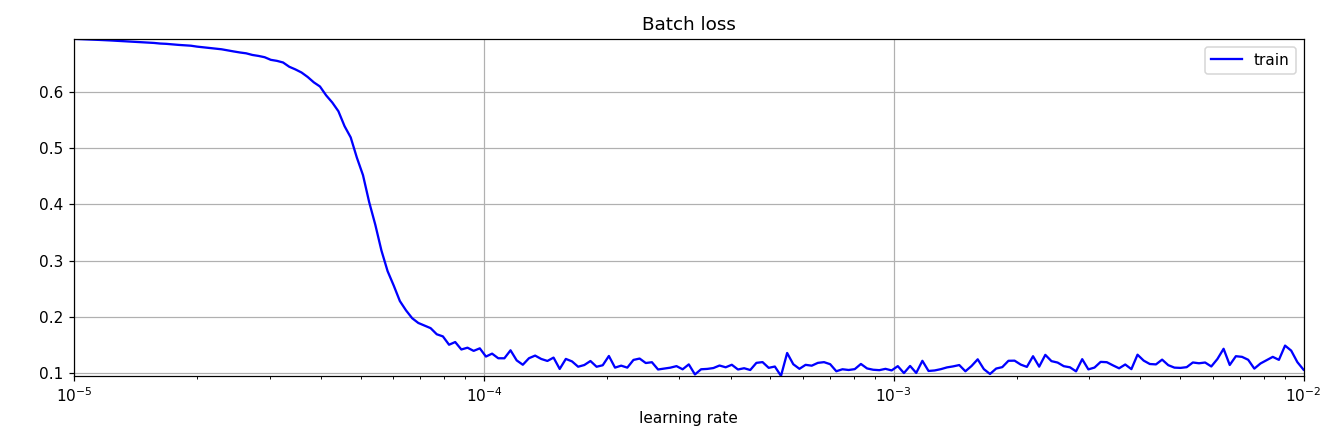

In [24]:
%matplotlib notebook
#-- Colab users should use `inline`
# %matplotlib inline

oModel        = GetModel().to(device)
oOptim        = optim.AdamW(oModel.parameters(), lr=0.1, betas=(0.9, 0.99), weight_decay=5e-3)
vLearningRate = np.logspace(-5, -2, 201)
oRecorder     = LearningRateSweep(oModel, oTrainDL, LossFunc, oOptim, vLearningRate)

For Colab users:

In [6]:
#%matplotlib inline
oRecorder.fig

### Train the model:

<IPython.core.display.Javascript object>


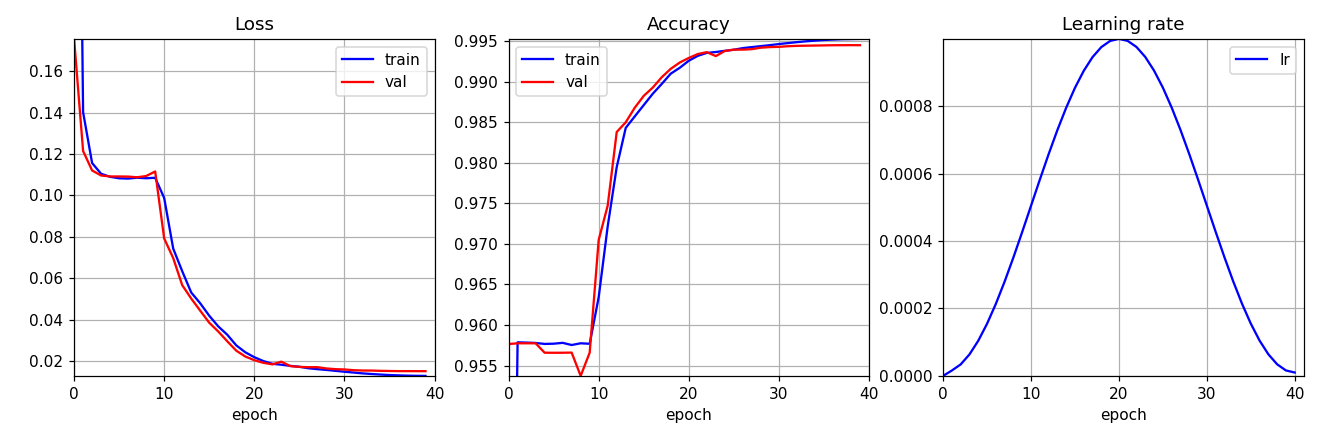

Epoch   0: | Train loss: 0.52395 | Val loss: 0.17571 | Train Accuracy: 0.8763 | Val Accuracy: 0.9577 | epoch time: 66.422 | <-- Checkpoint!
Epoch   1: | Train loss: 0.14027 | Val loss: 0.12152 | Train Accuracy: 0.9579 | Val Accuracy: 0.9577 | epoch time: 66.201 | <-- Checkpoint!
Epoch   2: | Train loss: 0.11569 | Val loss: 0.11209 | Train Accuracy: 0.9578 | Val Accuracy: 0.9577 | epoch time: 66.672 | <-- Checkpoint!
Epoch   3: | Train loss: 0.11049 | Val loss: 0.10966 | Train Accuracy: 0.9578 | Val Accuracy: 0.9577 | epoch time: 65.969 | <-- Checkpoint!
Epoch   4: | Train loss: 0.10902 | Val loss: 0.10920 | Train Accuracy: 0.9577 | Val Accuracy: 0.9566 | epoch time: 67.585 | <-- Checkpoint!
Epoch   5: | Train loss: 0.10832 | Val loss: 0.10920 | Train Accuracy: 0.9577 | Val Accuracy: 0.9566 | epoch time: 66.919 | <-- Checkpoint!
Epoch   6: | Train loss: 0.10817 | Val loss: 0.10913 | Train Accuracy: 0.9578 | Val Accuracy: 0.9566 | epoch time: 69.129 | <-- Checkpoint!
Epoch   7: | Train l

In [25]:
%matplotlib notebook

oModel = GetModel().to(device)
oOptim = optim.AdamW(oModel.parameters(), lr=0, betas=(0.9, 0.99), weight_decay=5e-3)

iterPerEpoch  = len(oTrainDL)
numEpochs     = 40
numIter       = numEpochs * iterPerEpoch
minLR         = 1e-5
maxLR         = 1e-3
vLearningRate = minLR + .5 * (maxLR - minLR) * (1 + np.cos(np.arange(numIter) / numIter * 2*np.pi + np.pi))

oScheduler = OneCycleScheduler(oOptim, vLearningRate)
TrainModel(oModel, oTrainDL, oTestDL, LossFunc, numEpochs, oOptim, oScheduler)

In [22]:
#-- Load model:
oModel = GetModel().to(device)
oModel.load_state_dict(torch.load('BestModelParameters.pt'))

<All keys matched successfully>

In [23]:
#-- Save model:
torch.save(oModel.state_dict(), 'BestNotesModel.pt')

In [24]:
#-- Load model:
oModel = GetModel().to(device)
oModel.load_state_dict(torch.load('BestNotesModel.pt'))

<All keys matched successfully>

### Create a test model
The test model is a copy of the trained model, which also outputs the hidden state of the RNN

In [25]:
import copy
oTrainedModel = copy.deepcopy(oModel)

class RnnTestModel(nn.Module):
    def __init__(self):
        super(RnnTestModel, self).__init__()
        self.gru    = oTrainedModel.gru
        self.linear = oTrainedModel.linear
        self.gru.flatten_parameters()
    
    def forward(self, tX, mH=None):
        
        if mH is None:
            mH, mNextH = self.gru(tX)
        else:
            mH, mNextH = self.gru(tX, mH)
        mZ = self.linear(mH)
        
        return nn.Sigmoid()(mZ), mNextH
    
def GetTestModel():
    oModel = RnnTestModel()
    oModel.train(False)
    return oModel

GetTestModel()

RnnTestModel(
  (gru): GRU(88, 750, num_layers=3, dropout=0.5)
  (linear): Linear(in_features=750, out_features=88, bias=True)
)

### Generate data from RNN model:

In [26]:
def Sample(oModel, length):
    #-- 
    vX   = torch.zeros(1, 1, 88)
    mOut = torch.zeros(88, length)

    for ii in range(length):

        vX = vX.to(device)
        if ii == 0:
            vP, mNextH = oModel(vX)
        else:
            vP, mNextH = oModel(vX, mNextH)
            
        mNextH = mNextH.to(device)

        vNotes     = torch.bernoulli(vP)
        mOut[:,ii] = vNotes
        vX         = vNotes
    
    return mOut

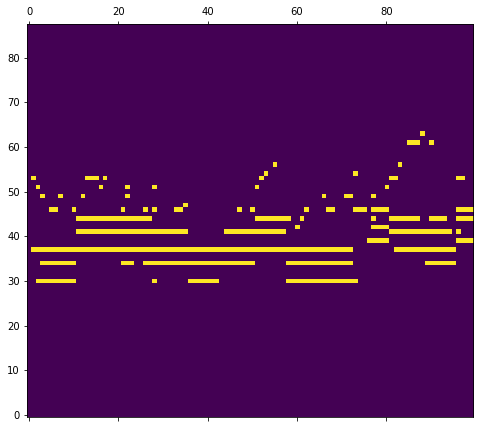

In [36]:
#%matplotlib inline

oTestModel = GetTestModel()
mOut       = Sample(oTestModel, 200).detach().cpu().numpy()

_, ax = plt.subplots(figsize=(8, 10))
ax.matshow(mOut[:,:1000:2], origin='lower')
plt.show()

In [37]:
PlayMidi(mOut, Fs=20)